## Imports

In [3]:
from SCTransform import SCTransform
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [9]:
#adata = sc.datasets.pbmc3k()
datapath='input_vizgen_liver/alldata/'
ad_sc_full = sc.read_h5ad(datapath+'sc_liver_data.h5ad')
ad_sc_full

AnnData object with n_obs × n_vars = 185894 × 31053

In [8]:
ad_sc_down = sc.read_h5ad(datapath+'sc_liver_data_downsample.h5ad')
ad_sc_down.obs_names_make_unique()
ad_sc_down

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 18754 × 31053

In [10]:
ad_sp_down=sc.read_h5ad(datapath+'spatial_quadrant.h5ad')
ad_sp_down

AnnData object with n_obs × n_vars = 87210 × 347

In [11]:
ad_sp_full=sc.read(datapath+'Blank_genes_removed.csv').transpose()
ad_sp_full.var_names_make_unique()
ad_sp_full

AnnData object with n_obs × n_vars = 395215 × 347

## Run SCTransform

In [ ]:
#####perform on single cell 

In [13]:
%%time
ad_sc_full_sct = SCTransform(ad_sc_full,
                        min_cells=5,
                        gmean_eps=1,
                        n_genes=2000,
                        n_cells=None, #use all cells
                        bin_size=500,
                        bw_adjust=3,
                        inplace=False)

CPU times: user 1min, sys: 43.9 s, total: 1min 44s
Wall time: 5min 45s


## Plot the fit parameters

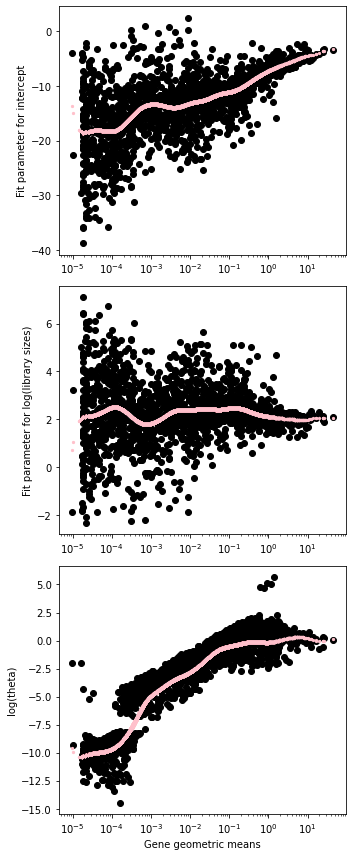

In [14]:
# Pull out the fit parameters (both step1 and extrapolated)
intercept1 = ad_sc_full_sct.var['Intercept_step1_sct'].values
filt = np.invert(np.isnan(intercept1))

gmean = 10**ad_sc_full_sct.var['log10_gmean_sct'].values
gmean1 = gmean[filt]
intercept1 = intercept1[filt]

intercept = ad_sc_full_sct.var['Intercept_sct'].values
logumi = ad_sc_full_sct.var['log_umi_sct'].values
logumi1 = ad_sc_full_sct.var['log_umi_step1_sct'].values[filt]
theta = ad_sc_full_sct.var['theta_sct'].values
theta1 = ad_sc_full_sct.var['dispersion_step1_sct'].values[filt]
theta1 = gmean1 / (10**theta1 - 1)

# Do the plotting
fig,axs = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches((5,12))
ax=axs[0]
ax.scatter(gmean1,intercept1,color='k'); 
ax.scatter(gmean,intercept,color='pink',s=5);
ax.set_ylabel('Fit parameter for intercept')
ax.set_xscale('log')

ax=axs[1]
ax.scatter(gmean1,logumi1,color='k'); 
ax.scatter(gmean,logumi,color='pink',s=5);
ax.set_ylabel('Fit parameter for log(library sizes)')
ax.set_xscale('log')

ax=axs[2]
ax.scatter(gmean1,np.log(theta1),color='k'); 
ax.scatter(gmean,np.log(theta),color='pink',s=5);
ax.set_xlabel('Gene geometric means')
ax.set_ylabel('log(theta)')
ax.set_xscale('log')
fig.tight_layout()

In [15]:
sp_cellname=ad_sp_full.obs_names.to_numpy()
sp_genename=ad_sp_full.var_names.to_numpy()
sc_cellname=ad_sc_full.obs_names.to_numpy()
sc_genename=ad_sc_full.var_names.to_numpy()
print(len(sp_cellname),len(sp_genename))
print(len(sc_cellname),len(sc_genename))


395215 347
185894 31053


In [18]:
#find common genes 
index_sc=[]
index_sp=[]
d={}
for j in range(len(sc_genename)):
    name=sc_genename[j]
    d[name]=j
    
for i in range(len(sp_genename)):
    name=sp_genename[i]
    try: 
        d[name]
        flag=1
    except KeyError: 
        flag=0
    if flag==1:
        index_sc.append(d[name])
        index_sp.append(i)

print(len(index_sc),len(index_sp))

346 346


In [19]:
new_ad_sc_full=ad_sc_full[:,index_sc]
new_ad_sc_full

View of AnnData object with n_obs × n_vars = 185894 × 346

In [20]:
new_ad_sp_full=ad_sp_full[:,index_sp]
new_ad_sp_full

View of AnnData object with n_obs × n_vars = 395215 × 346

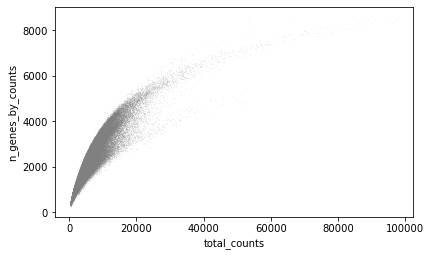

In [31]:
ad_sc_full.var['mt'] = ad_sc_full.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ad_sc_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(ad_sc_full, x='total_counts', y='n_genes_by_counts')

Trying to set attribute `.var` of view, copying.


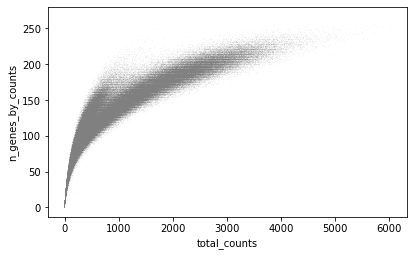

In [30]:
new_ad_sp_full.var['mt'] = new_ad_sp_full.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(new_ad_sp_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(new_ad_sp_full, x='total_counts', y='n_genes_by_counts')

In [61]:
expression=ad_sp_full.X
print(expression.shape)
n=expression.shape[1]

(395215, 347)


In [71]:
from statsmodels.discrete.discrete_model import NegativeBinomialP
#cellsum=np.sum(expression,axis=1)
cellsum=np.sum(expsc,axis=1)
(x,y) = np.unique(cellsum, return_counts=True)
intercept=np.ones(len(x),dtype=int)
xx=np.asarray((x,intercept)).T
xx=xx.astype(np.int64)

model_nb = NegativeBinomialP(y, xx, p=2)
res_nb = model_nb.fit(method='bfgs', maxiter=5000, maxfun=5000)
    #print(res_nb.summary())
estimated_alpha=res_nb.params[2]
print(estimated_alpha)

Optimization terminated successfully.
         Current function value: 68.435396
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
9.841140237344317e+28


/Users/agrawal/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


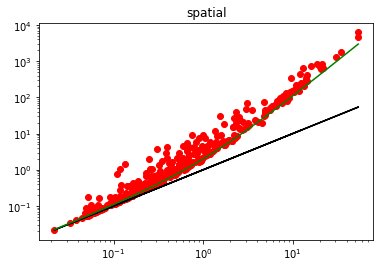

In [65]:
x=np.mean(expression,axis=0)
y=np.var(expression,axis=0)
    
mu=np.sort(x)    
estimated_alpha=1    
myvar=mu+estimated_alpha*mu**2
plt.plot(x,y,'ro')  
plt.plot(x,x,'k-')
plt.plot(mu,myvar,'g-',label='NB')    
plt.title('spatial')    
plt.yscale('log')
plt.xscale('log')    
    

In [49]:
sc.pp.filter_genes(ad_sc_full, min_cells=500)
print(ad_sc_full)

AnnData object with n_obs × n_vars = 185894 × 14856
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'


In [66]:
expsc=ad_sc_full.X
n=expsc.shape[1]
expsc=expsc.toarray()
print(expsc.shape)

(185894, 14856)


In [67]:
xsc=np.mean(expsc,axis=0)
ysc=np.var(expsc,axis=0)

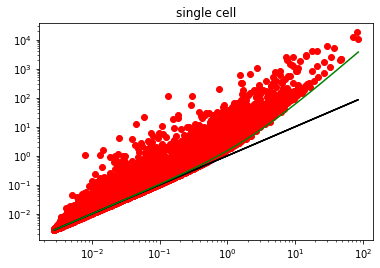

In [70]:
plt.plot(xsc,ysc,'ro')  
plt.plot(xsc,xsc,'k-')
plt.yscale('log')
plt.xscale('log')    
plt.title('single cell')    
mu=np.sort(xsc)    
estimated_alpha=0.5   
myvar=mu+estimated_alpha*mu**2 
plt.plot(mu,myvar,'g-',label='NB')    

In [24]:
#performed on common genes in single cells 
new_ad_sc_full_sct = SCTransform(new_ad_sc_full,
                        min_cells=5,
                        gmean_eps=1,
                        n_genes=500,
                        n_cells=None, #use all cells
                        bin_size=500,
                        bw_adjust=3,
                        inplace=False)

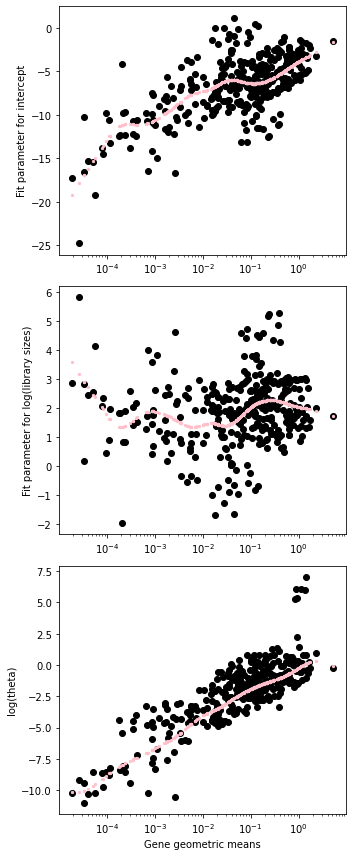

In [25]:
# Pull out the fit parameters (both step1 and extrapolated)
intercept1 = new_ad_sc_full_sct.var['Intercept_step1_sct'].values
filt = np.invert(np.isnan(intercept1))

gmean = 10**new_ad_sc_full_sct.var['log10_gmean_sct'].values
gmean1 = gmean[filt]
intercept1 = intercept1[filt]

intercept = new_ad_sc_full_sct.var['Intercept_sct'].values
logumi = new_ad_sc_full_sct.var['log_umi_sct'].values
logumi1 = new_ad_sc_full_sct.var['log_umi_step1_sct'].values[filt]
theta = new_ad_sc_full_sct.var['theta_sct'].values
theta1 = new_ad_sc_full_sct.var['dispersion_step1_sct'].values[filt]
theta1 = gmean1 / (10**theta1 - 1)

# Do the plotting
fig,axs = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches((5,12))
ax=axs[0]
ax.scatter(gmean1,intercept1,color='k'); 
ax.scatter(gmean,intercept,color='pink',s=5);
ax.set_ylabel('Fit parameter for intercept')
ax.set_xscale('log')

ax=axs[1]
ax.scatter(gmean1,logumi1,color='k'); 
ax.scatter(gmean,logumi,color='pink',s=5);
ax.set_ylabel('Fit parameter for log(library sizes)')
ax.set_xscale('log')

ax=axs[2]
ax.scatter(gmean1,np.log(theta1),color='k'); 
ax.scatter(gmean,np.log(theta),color='pink',s=5);
ax.set_xlabel('Gene geometric means')
ax.set_ylabel('log(theta)')
ax.set_xscale('log')
fig.tight_layout()

In [73]:
sc.pp.filter_cells(new_ad_sp_full, min_counts=10)
sc.pp.normalize_total(new_ad_sp_full, inplace=True)
sc.pp.log1p(new_ad_sp_full)

In [74]:
new_ad_sp_full

AnnData object with n_obs × n_vars = 393261 × 346
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [77]:
new_ad_sc_full

View of AnnData object with n_obs × n_vars = 185894 × 346

In [75]:
#performed on spatial cells 
new_ad_sp_full_sct = SCTransform(new_ad_sp_full,
                        min_cells=10,
                        gmean_eps=1,
                        n_genes=500,
                        n_cells=None, #use all cells
                        bin_size=200,
                        bw_adjust=3,
                        inplace=False)

<ipython-input-76-258735b20062>:33: RuntimeWarning: invalid value encountered in log
  ax.scatter(gmean,np.log(theta),color='pink',s=5);


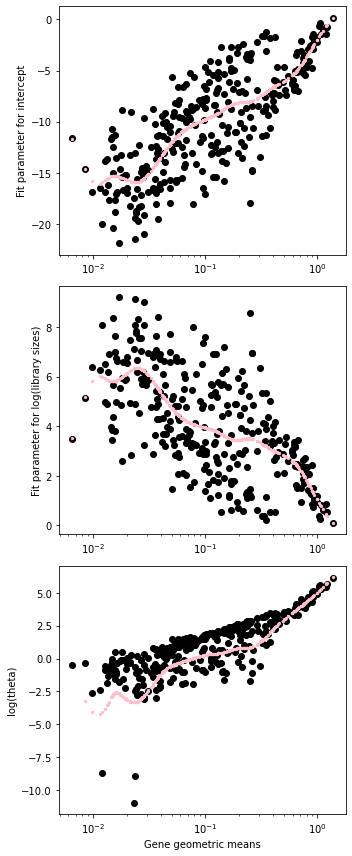

In [76]:
# Pull out the fit parameters (both step1 and extrapolated)
intercept1 = new_ad_sp_full_sct.var['Intercept_step1_sct'].values
filt = np.invert(np.isnan(intercept1))

gmean = 10**new_ad_sp_full_sct.var['log10_gmean_sct'].values
gmean1 = gmean[filt]
intercept1 = intercept1[filt]

intercept = new_ad_sp_full_sct.var['Intercept_sct'].values
logumi = new_ad_sp_full_sct.var['log_umi_sct'].values
logumi1 = new_ad_sp_full_sct.var['log_umi_step1_sct'].values[filt]
theta = new_ad_sp_full_sct.var['theta_sct'].values
theta1 = new_ad_sp_full_sct.var['dispersion_step1_sct'].values[filt]
theta1 = gmean1 / (10**theta1 - 1)

# Do the plotting
fig,axs = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches((5,12))
ax=axs[0]
ax.scatter(gmean1,intercept1,color='k'); 
ax.scatter(gmean,intercept,color='pink',s=5);
ax.set_ylabel('Fit parameter for intercept')
ax.set_xscale('log')

ax=axs[1]
ax.scatter(gmean1,logumi1,color='k'); 
ax.scatter(gmean,logumi,color='pink',s=5);
ax.set_ylabel('Fit parameter for log(library sizes)')
ax.set_xscale('log')

ax=axs[2]
ax.scatter(gmean1,np.log(theta1),color='k'); 
ax.scatter(gmean,np.log(theta),color='pink',s=5);
ax.set_xlabel('Gene geometric means')
ax.set_ylabel('log(theta)')
ax.set_xscale('log')
fig.tight_layout()

In [78]:
#new_ad_sc_full
#new_ad_sp_full
print(new_ad_sp_full_sct)
print(new_ad_sc_full_sct)

AnnData object with n_obs × n_vars = 393261 × 346
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
AnnData object with n_obs × n_vars = 185894 × 341
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'


In [108]:
print(new_ad_sp_full_sct.X[0:5,0:5])

  (0, 2)	0.27316746
  (0, 4)	0.39213172
  (2, 0)	0.11484632
  (2, 1)	0.15271752
  (2, 2)	0.25409088
  (3, 0)	0.30919948
  (3, 1)	0.73210096
  (3, 2)	0.37100565
  (3, 3)	0.49517554
  (4, 0)	0.16912605
  (4, 1)	0.0606239


In [107]:
print(ad_sp_full.X[0:5,0:5])

[[ 8.  6. 96.  5.  8.]
 [ 6.  4.  3.  5.  0.]
 [ 5.  5. 30.  3.  1.]
 [ 1.  3.  5.  2.  0.]
 [33. 19. 11. 12.  0.]]


In [109]:
sc.pp.pca(new_ad_sc_full_sct)
sc.pp.neighbors(new_ad_sc_full_sct,n_pcs=30)
sc.tl.umap(new_ad_sc_full_sct)
sc.tl.leiden(new_ad_sc_full_sct,resolution=1.0)



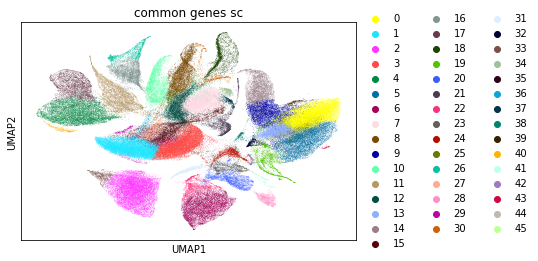

In [117]:
sc.pl.umap(new_ad_sc_full_sct,color=['leiden'],title=["common genes sc"],wspace=0.2)

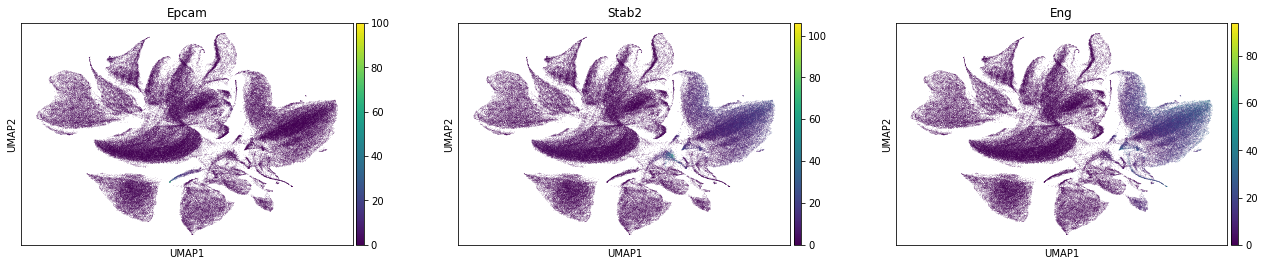

In [114]:
sc.pl.umap(new_ad_sc_full_sct,color=['Epcam','Stab2','Eng'],wspace=0.2)

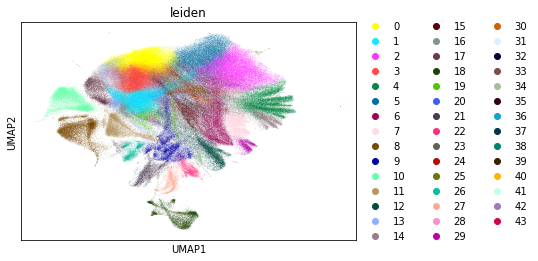

In [116]:
sc.pp.pca(new_ad_sp_full_sct)
sc.pp.neighbors(new_ad_sp_full_sct,n_pcs=30)
sc.tl.umap(new_ad_sp_full_sct)
sc.tl.leiden(new_ad_sp_full_sct,resolution=1.0)
sc.pl.umap(new_ad_sp_full_sct,color=['leiden'],wspace=0.2)

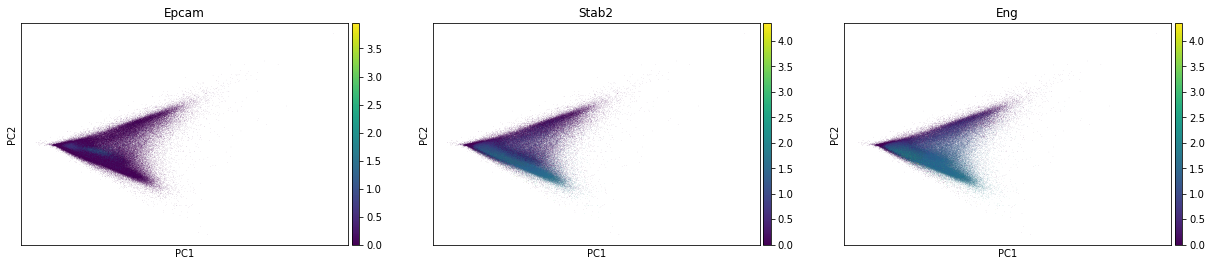

In [89]:
sc.pl.umap(new_ad_sp_full_sct,color=['Epcam','Stab2','Eng'],wspace=0.2)

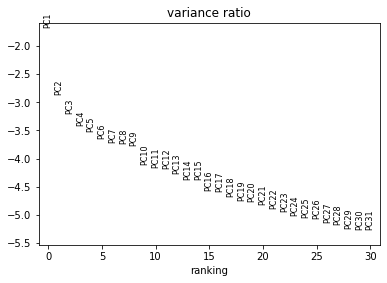

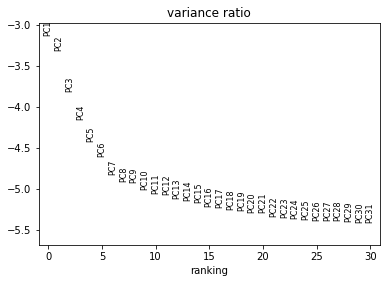

In [86]:
sc.pl.pca_variance_ratio(new_ad_sc_full_sct, log=True)
sc.pl.pca_variance_ratio(new_ad_sp_full_sct, log=True)

In [91]:
ad_sc_full_sct

AnnData object with n_obs × n_vars = 185894 × 23907
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'

In [92]:
sc.pp.pca(ad_sc_full_sct)
sc.pp.neighbors(ad_sc_full_sct,n_pcs=30)
sc.tl.umap(ad_sc_full_sct)
sc.tl.leiden(ad_sc_full_sct,resolution=1.0)
sc.pl.umap(ad_sc_full_sct,color=['leiden'],wspace=0.2)

In [118]:
sc.pl.umap(ad_sc_full_sct,color=['leiden'],title=["full genes sc"],wspace=0.2)

KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: ['X_pca']."

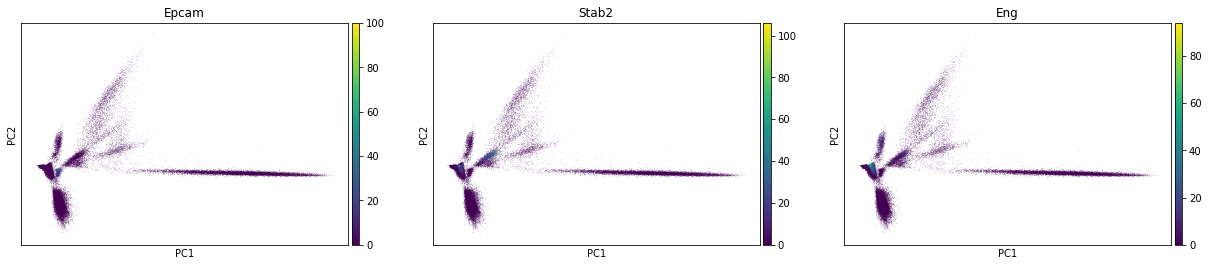

In [93]:
sc.pl.pca(ad_sc_full_sct,color=['Epcam','Stab2','Eng'])